# KFRE Validation

## Background

The Kidney Failure Risk Equation (KFRE) by Tangri et al.
Tangri et al. developed the Kidney Failure Risk Equation (KFRE) to predict the risk of progression to kidney failure in patients with chronic kidney disease (CKD). They utilized data from multiple cohort studies involving patients with CKD stages 3 to 5. The researchers identified key predictors of kidney failure, including age, sex, estimated glomerular filtration rate (eGFR), and urine albumin-to-creatinine ratio (ACR). They then used statistical modeling to create equations that estimate the risk of kidney failure at 2 and 5 years. The KFRE has been validated in various populations and is used to guide clinical decision-making and patient counseling.  

To reproduce the work of Tangri et al., I created a Python library called `kfre`. This library implements the original KFRE equations, allowing users to easily calculate the `2-year` and `5-year` risk of kidney failure. The calculations are based on input parameters such as `age`, `sex`, `eGFR`, and `uACR` for the `4-variable equation`, and adding diabetes mellitus and hypertension for the `6-variable equation`. The `8-variable equation` includes all the variables from the 4-variable model and additionally introduces `serum albumin`, `serum phosphorous`, `serum bicarbonate`, and `calcium`. By translating these equations into Python code, I made it straightforward for healthcare professionals and researchers to utilize the KFRE in their own analyses and decision-making processes.

For an in-depth, supplementary usage guide, visit the link to the official documentation below:
https://lshpaner.github.io/kfre/

## Import Requisite Libraries

In [1]:
########################### Import Requisite Libraries #########################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    auc,
    roc_curve,
    precision_score,
    average_precision_score,
    recall_score,
    roc_auc_score,
    brier_score_loss,
    precision_recall_curve,
    precision_score,
)
import os
import sys
import pprint
import warnings
import textwrap
import kfre
from kfre import *

################################################################################
# Add the parent directory to sys.path to access 'functions.py'
sys.path.append(os.path.join(os.pardir))
from py_scripts.functions import *
from py_scripts.esrd_functions import *

################################################################################
print("Python version:")
print(sys.version)
print()
print(f"Pandas Version = {pd.__version__}")
print(f"Seaborn Version = {sns.__version__}")
print(f"Numpy Version = {np.__version__}")
print(f"KFRE Version = {kfre.__version__}")

Python version:
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]

Pandas Version = 2.2.2
Seaborn Version = 0.13.2
Numpy Version = 1.26.4
KFRE Version = 0.1.8


## Set Paths

In [2]:
base_path = os.path.join(os.pardir)

# Go up one level from 'notebooks' to the parent directory, then into the 'data' folder
data_path = os.path.join(os.pardir, "data")
data_output = os.path.join(os.pardir, "data_output")

image_path_png = os.path.join(
    base_path,
    "images",
    "png_images/performance_assessment",
)
image_path_svg = os.path.join(
    base_path,
    "images",
    "svg_images/performance_assessment",
)

# Use the function to ensure the 'data' directory exists
ensure_directory(data_path)
ensure_directory(data_output)
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

# Read the file into a DataFrame
df = pd.read_excel(os.path.join(data_path, "KFRE_prepped.xlsx")).set_index("Patient_ID")

Directory exists: ..\data
Directory exists: ..\data_output
Directory exists: ..\images\png_images/performance_assessment
Directory exists: ..\images\svg_images/performance_assessment


In [3]:
df.head()  # inspect first 5 rows of data

,Age,SEX,HTN,DM,GFR,ACR,Ca,P,Alb,TCO2,ESRD,ESRD_dur,sex_cat,years,2_year_outcome,5_year_outcome,ckd_stage,CKD Stage 3 - 5,Age_Group
Patient_ID,,,,,,,,,,,,,,,,,,,
723027400,61,1,1,0,9.148234,10.000000,6.0,4.0,2.6,16.0,0,2086,Male,6,0,0,CKD Stage 5,CKD Stage 3 - 5,60-69
904532344,30,0,1,1,153.974871,29.000000,9.4,4.5,4.0,24.0,0,2357,Female,6,0,0,CKD Stage 1,Not classified,30-39
890205650,55,1,0,0,66.810414,25.774259,9.2,1.6,4.3,18.0,0,265,Male,1,0,0,CKD Stage 2,Not classified,50-59
317865962,35,1,0,0,89.347060,28.451303,10.5,2.9,5.0,26.0,0,700,Male,2,0,0,CKD Stage 2,Not classified,30-39
968356501,66,1,1,0,7.316171,0.000000,7.7,6.5,3.5,14.0,1,3,Male,0,1,1,CKD Stage 5,CKD Stage 3 - 5,60-69


In [4]:
data_types(df)

,Column/Variable,Data Type,# of Nulls,Percent Null
0,Age,int64,0,0.0
1,SEX,int64,0,0.0
2,HTN,int64,0,0.0
3,DM,int64,0,0.0
4,GFR,float64,0,0.0
5,ACR,float64,0,0.0
6,Ca,float64,0,0.0
7,P,float64,0,0.0
8,Alb,float64,0,0.0
9,TCO2,float64,0,0.0


In [5]:
df = add_kfre_risk_col(
    df=df,
    age_col="Age",
    sex_col="sex_cat",
    eGFR_col="GFR",
    uACR_col="ACR",
    dm_col="DM",
    htn_col="HTN",
    albumin_col="Alb",
    phosphorous_col="P",
    bicarbonate_col="TCO2",
    calcium_col="Ca",
    num_vars=[4, 6, 8],
    years=(2, 5),
    is_north_american=False,
    copy=True,  # Modify the original DataFrame directly
)
# The resulting DataFrame 'df' now includes new columns with risk
# predictions for each model and time frame
kfre_cols = [col for col in df.columns if "kfre" in col]
df[kfre_cols] = (
    df[kfre_cols].map(lambda x: f"{x:.6f}" if isinstance(x, float) else x).astype(float)
)  # rem. sci not and ensure cols are floats

In [6]:
# Call the function with desired parameters
columns_to_highlight = df[[col for col in df.columns if "kfre" in col]]
df_styled = highlight_columns(
    df.head(),
    columns=columns_to_highlight,
    color="#B85C00",
)

# Display the styled DataFrame
df_styled

,Age,SEX,HTN,DM,GFR,ACR,Ca,P,Alb,TCO2,ESRD,ESRD_dur,sex_cat,years,2_year_outcome,5_year_outcome,ckd_stage,CKD Stage 3 - 5,Age_Group,kfre_4var_2year,kfre_4var_5year,kfre_6var_2year,kfre_6var_5year,kfre_8var_2year,kfre_8var_5year
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,
723027400,61,1,1,0,9.148234,10.000000,6.000000,4.000000,2.600000,16.000000,0,2086,Male,6,0,0,CKD Stage 5,CKD Stage 3 - 5,60-69,0.121840,0.395347,0.131929,0.415467,0.581066,0.980034
904532344,30,0,1,1,153.974871,29.000000,9.400000,4.500000,4.000000,24.000000,0,2357,Female,6,0,0,CKD Stage 1,Not classified,30-39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001
890205650,55,1,0,0,66.810414,25.774259,9.200000,1.600000,4.300000,18.000000,0,265,Male,1,0,0,CKD Stage 2,Not classified,50-59,0.000370,0.001432,0.000362,0.001374,0.000585,0.002628
317865962,35,1,0,0,89.347060,28.451303,10.500000,2.900000,5.000000,26.000000,0,700,Male,2,0,0,CKD Stage 2,Not classified,30-39,0.000049,0.000189,0.000049,0.000184,0.000045,0.000202
968356501,66,1,1,0,7.316171,0.000000,7.700000,6.500000,3.500000,14.000000,1,3,Male,0,1,1,CKD Stage 5,CKD Stage 3 - 5,60-69,0.000099,0.000385,0.000099,0.000377,0.004638,0.020696


For the 4 variable KFRE, feel free to match these calculations with the following online calculator:

https://qxmd.com/calculate/calculator_308/kidney-failure-risk-equation-4-variable


For the 8 variable KFRE, feel free to match these calculations with the following online calculator:

https://kidneyfailurerisk.com/

## Subset The Data For Only Stages 3-4

In [7]:
# Filter for CKD Stages 3 through 5
df_ckd_3_to_5 = df[df["GFR"] < 60]

In [8]:
df_3_5 = df[df["CKD Stage 3 - 5"] != "Not classified"]

In [9]:
print(
    f"There are {df_ckd_3_to_5.shape[0]} patients in stages 3-5 when the "
    "dataframe is filtered by `df_ckd_3_to_5`."
)
print(
    f"There are {df_3_5.shape[0]} patients in stages 3-5 when the dataframe "
    "is filtered by `df_3_5`."
)

There are 6569 patients in stages 3-5 when the dataframe is filtered by `df_ckd_3_to_5`.
There are 6569 patients in stages 3-5 when the dataframe is filtered by `df_3_5`.


## Save Out The Results

In [10]:
file_name = "kfre_3_5_preds.xlsx"  # Name of the output Excel file
file_path = os.path.join(data_path, file_name)


df_dict = {"KFRE_Stages_3_4": df_ckd_3_to_5}

save_dataframes_to_excel(file_path, df_dict, decimal_places=6)

DataFrames saved to ..\data\kfre_3_5_preds.xlsx


## Challenges in Predicting KFRE with GFR Less Than 10

Predicting the Kidney Failure Risk Equation (KFRE) for patients with an estimated glomerular filtration rate (eGFR) less than 10 ml/min/1.73 m² can be challenging due to several factors:

1. **Data Sparsity**: Patients with eGFR less than 10 ml/min/1.73 m² are relatively rare in the general population compared to those with higher eGFR values. This means there is less data available to develop and validate predictive models for this group.

2. **Rapid Disease Progression**: At such low eGFR levels, patients are typically very close to requiring dialysis or a kidney transplant. The disease progression in these patients can be more rapid and variable, making it harder to predict outcomes accurately.

3. **Clinical Interventions**: Patients with eGFR less than 10 ml/min/1.73 m² are often under close medical supervision and may receive interventions that can alter the natural course of the disease, such as the initiation of dialysis or changes in medication. These interventions can add variability to the outcomes, complicating predictions.

4. **Physiological Changes**: At very low eGFR levels, the body's physiology can undergo significant changes, which may not be fully captured by the variables included in the KFRE. This can reduce the model's predictive accuracy.

Despite these challenges, the KFRE can still provide valuable information for patients with very low eGFR, but it is important to interpret the results with caution and in the context of other clinical information. It is always recommended to consult with healthcare professionals for personalized medical advice and decision-making.


## Performance Assessment

1. We define Truth for `2-Year` and `5-Year` Outcomes    
2. Extract the true labels for the `2-year` and `5-year` outcomes from the DataFrame `df`.

3. Assign the true labels for the `2-year` outcome to y_true_2_yr and for the `5-year` outcome to `y_true_5_yr`.
4. Combine these true labels into a list `y_true`.

## Define Predictions for 4-Variable and 6-Variable KFREs for 2-Years and 5-Years

* Extract the predicted probabilities for the `4-variable` KFRE model for both the `2-year` and `5-year` outcomes.
* Assign these predictions to `y_pred_4var_2_yr` and `y_pred_4var_5_yr`, respectively.
* Similarly, extract and assign the predicted probabilities for the 6-variable KFRE model for both the `2-year` and `5-year` outcomes to `y_pred_6var_2_yr` and `y_pred_6var_5_yr`.
* Combine the 4-variable model predictions into a list preds_4var.

These steps set up the necessary true labels and predictions for subsequent performance evaluation and analysis of the `4-variable` and `6-variable` KFRE models for both `2-year` and `5-year` outcomes.

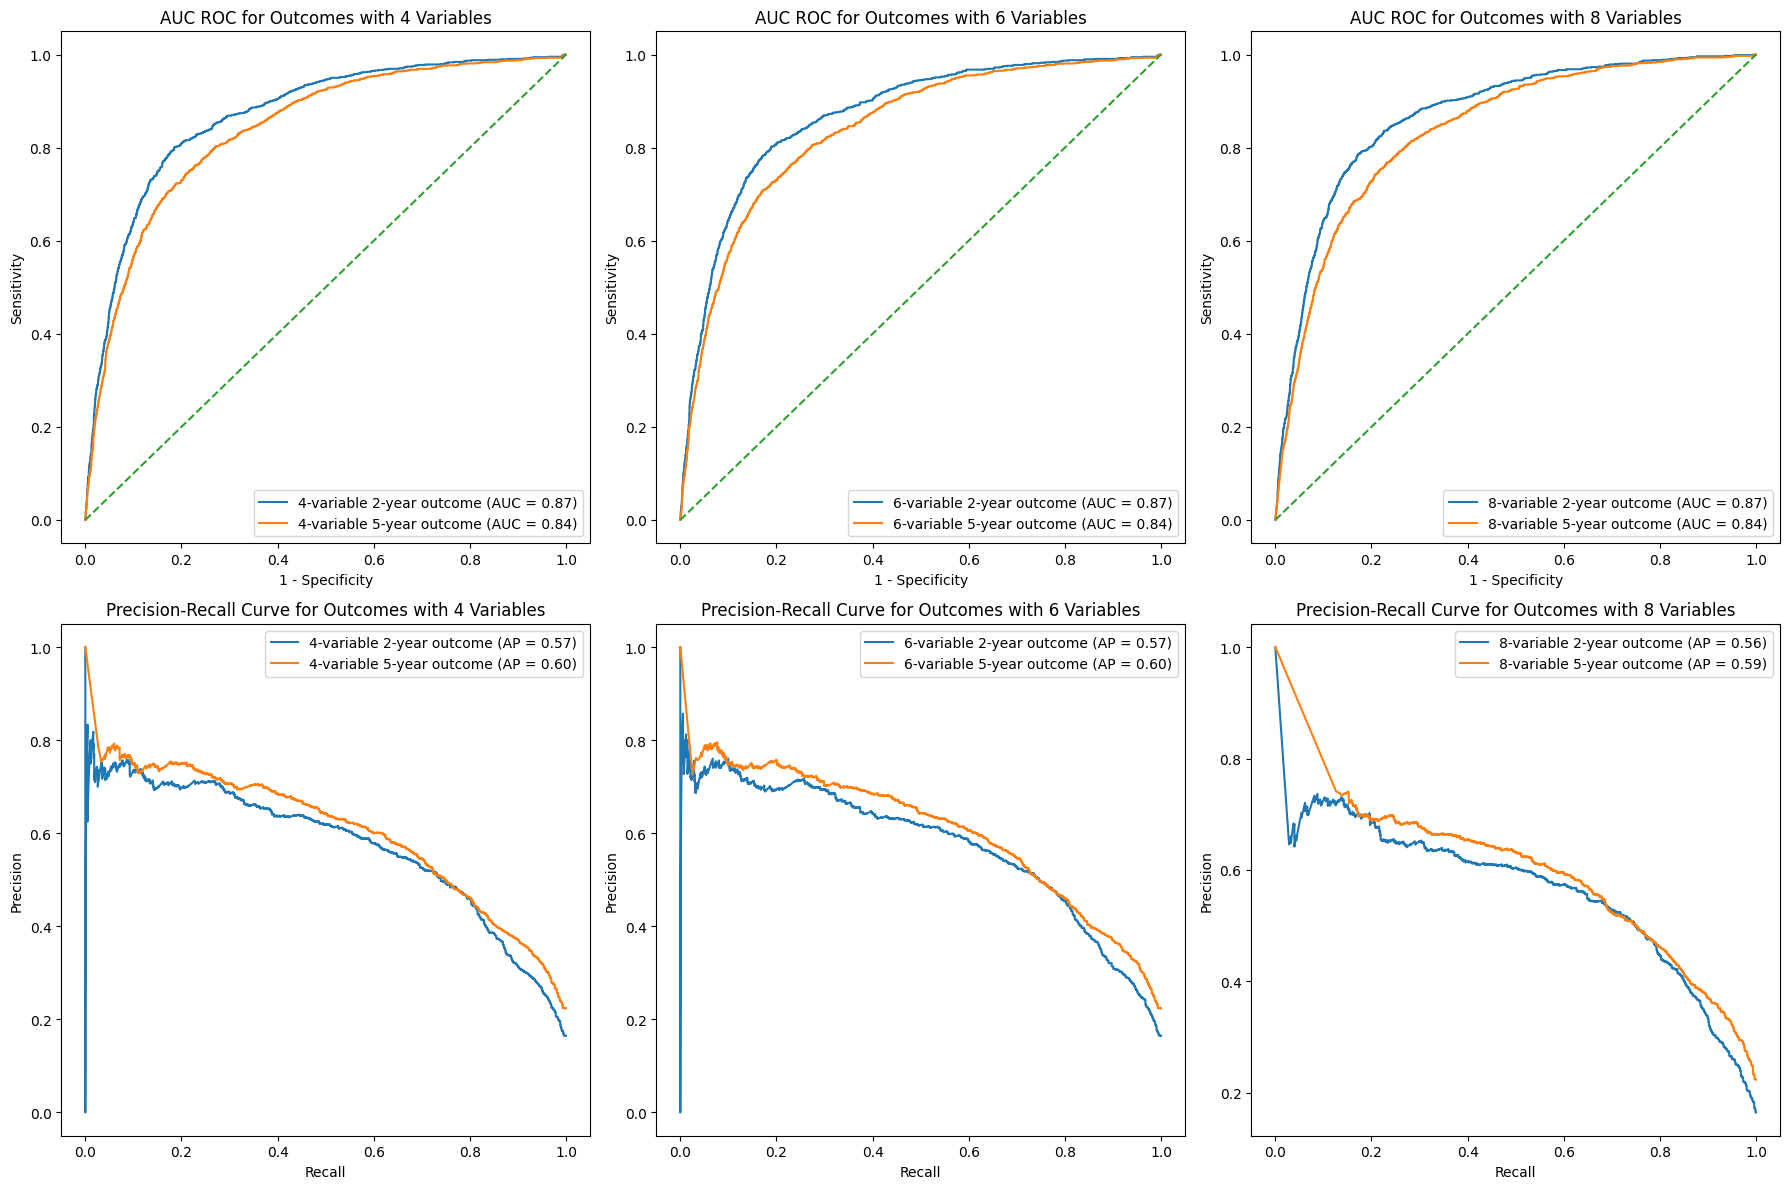

In [11]:
results = prep_and_plot_metrics_vars(
    df=df_ckd_3_to_5,
    num_vars=[4, 6, 8],
    fig_size=[6, 6],
    mode="both",  # Can be 'prep', 'plot', or 'both'
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    image_prefix="performance",  # Optional prefix for saved images
    bbox_inches="tight",  # Bounding box in inches for the saved images
    plot_type="both",  # Can be 'roc', 'pr', or 'both'
    save_plots=True,  # Whether to save plots
    show_years=[2, 5],  # Year outcomes to show in the plots
    plot_combinations=False,
    show_grids=True,
)

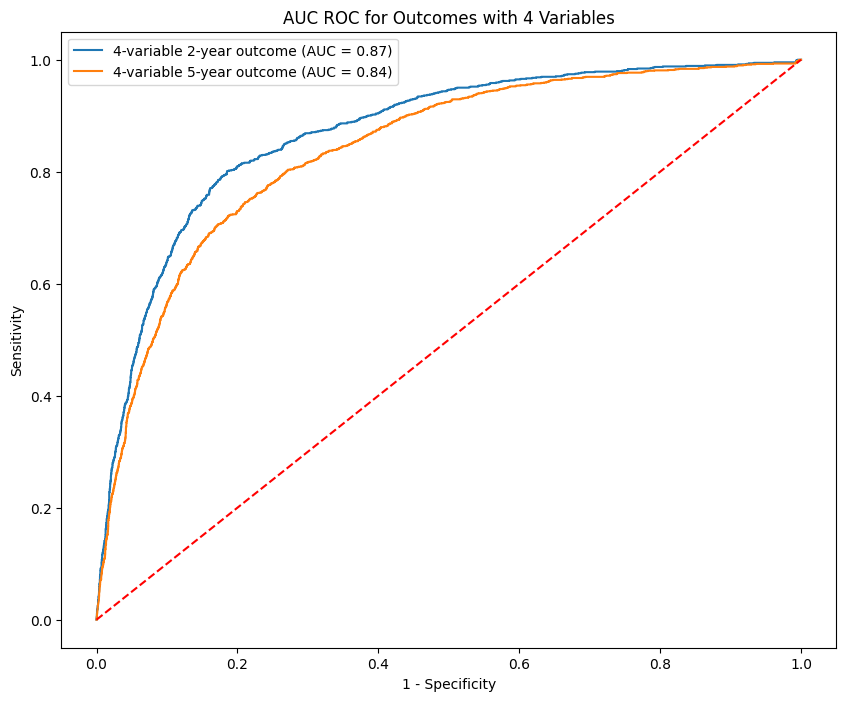

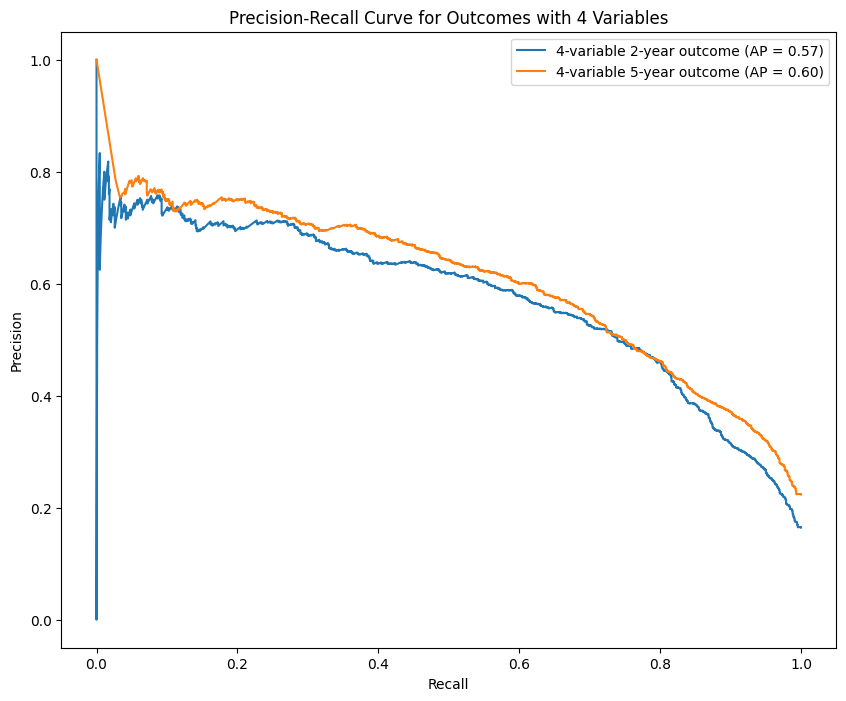

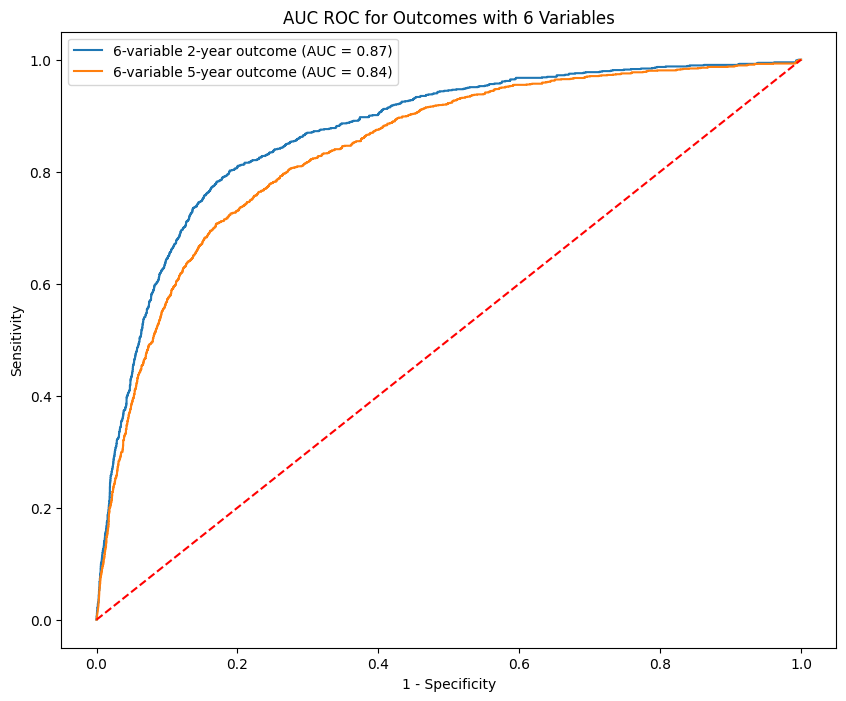

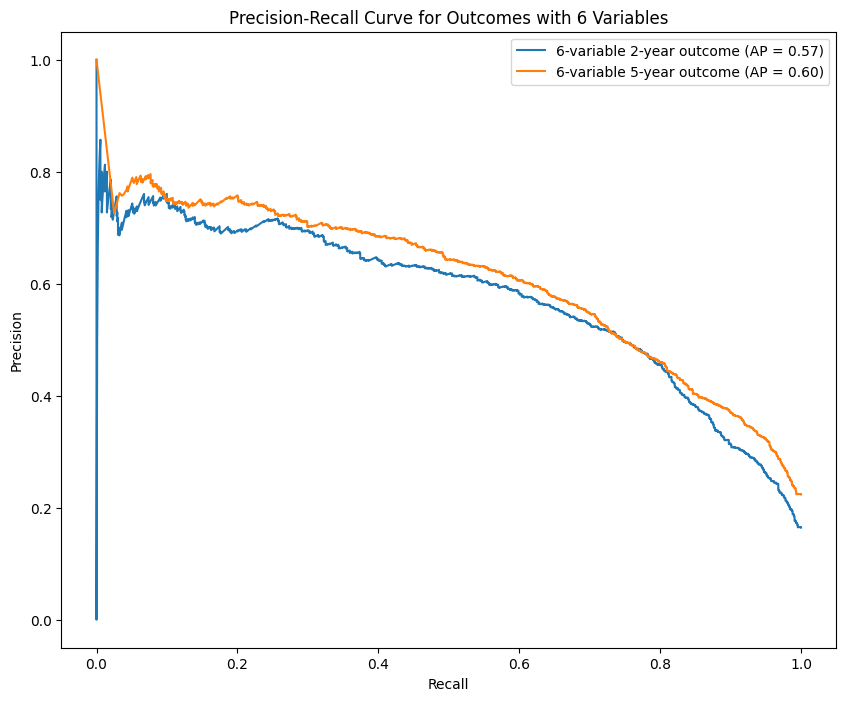

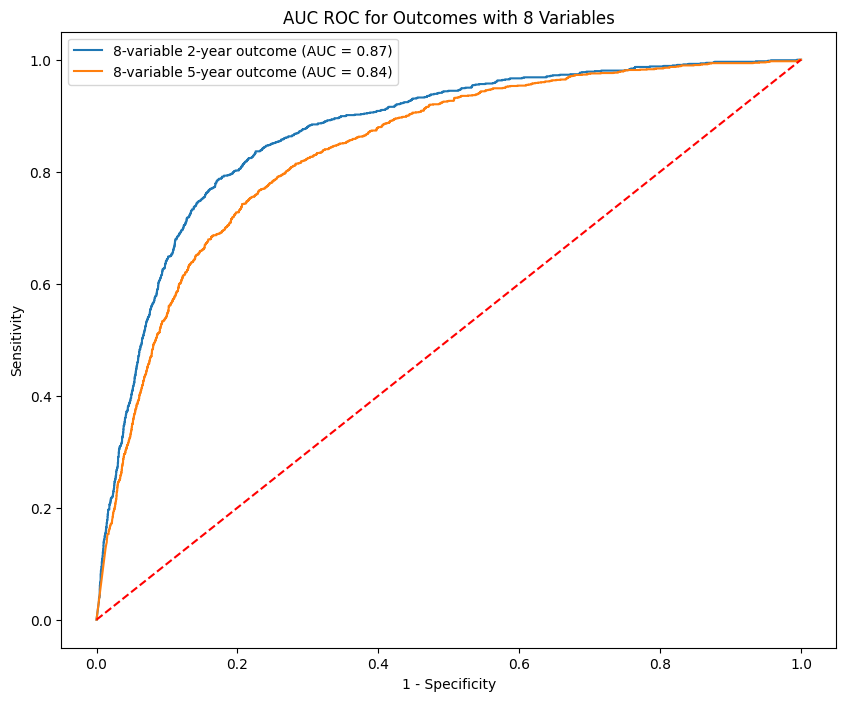

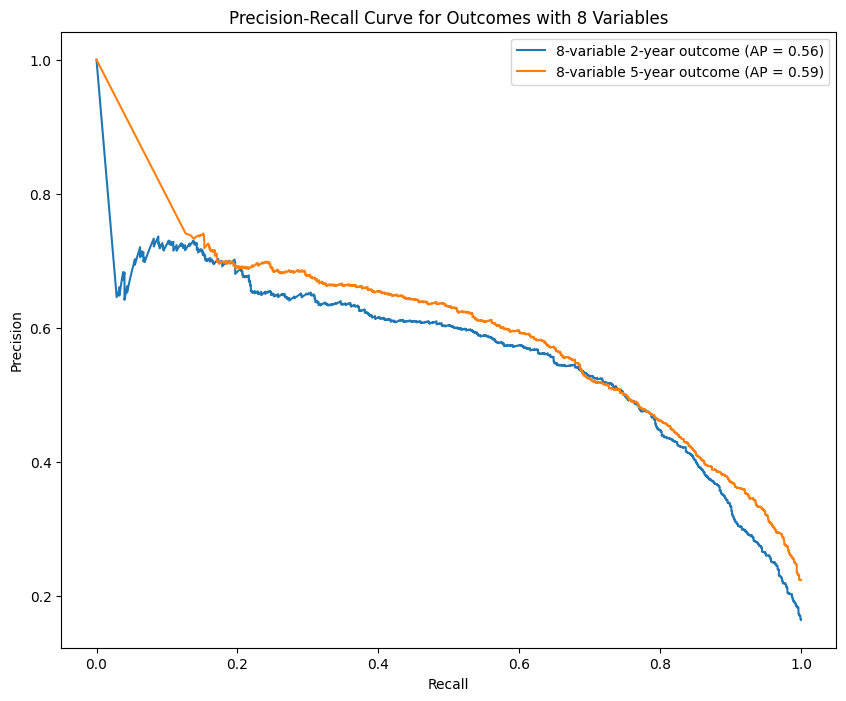

In [12]:
results = prep_and_plot_metrics_vars(
    df=df_ckd_3_to_5,
    num_vars=[4, 6, 8],
    fig_size=[10, 8],
    mode="both",  # Can be 'prep', 'plot', or 'both'
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    image_prefix="performance",  # Optional prefix for saved images
    bbox_inches="tight",  # Bounding box in inches for the saved images
    plot_type="both",  # Can be 'roc', 'pr', or 'both'
    save_plots=True,  # Whether to save plots
    show_years=[2, 5],  # Year outcomes to show in the plots
    plot_combinations=False,
    show_grids=False,
)

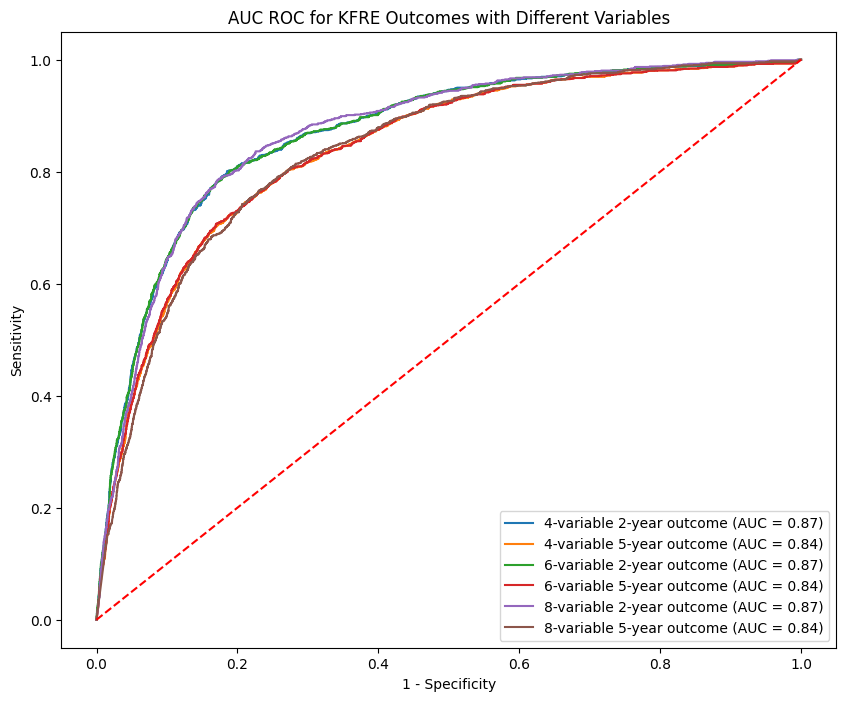

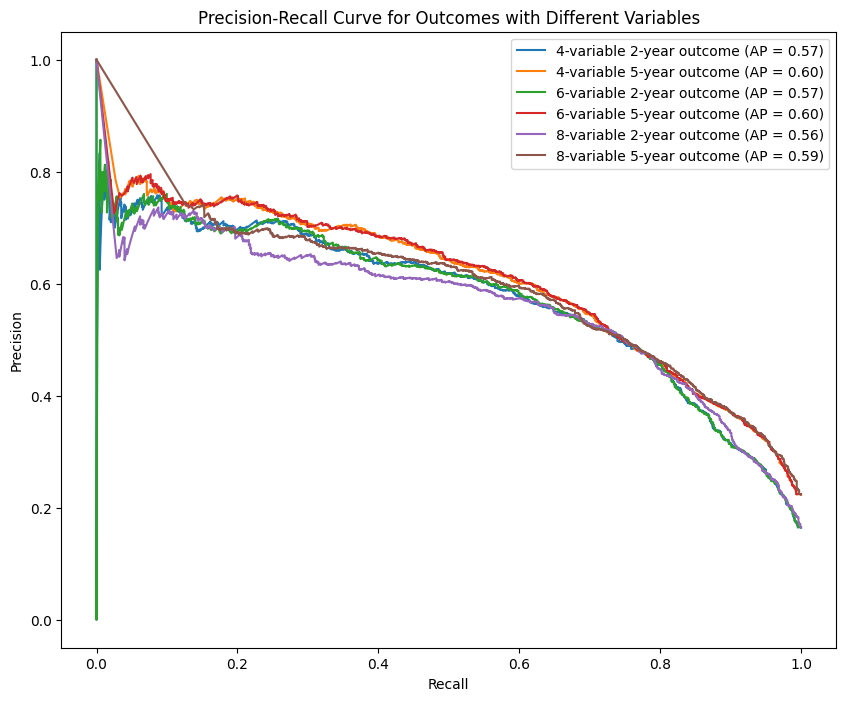

In [13]:
results = prep_and_plot_metrics_vars(
    df=df_ckd_3_to_5,
    num_vars=[4, 6, 8],
    fig_size=[10, 8],
    mode="both",  # Can be 'prep', 'plot', or 'both'
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    image_prefix="performance",  # Optional prefix for saved images
    bbox_inches="tight",  # Bounding box in inches for the saved images
    plot_type="both",  # Can be 'roc', 'pr', or 'both'
    save_plots=True,  # Whether to save plots
    show_years=[2, 5],  # Year outcomes to show in the plots
    plot_combinations=True,
    show_grids=False,
)

In [14]:
results = prep_and_plot_metrics_vars(
    df=df_ckd_3_to_5,
    num_vars=[4, 6, 8],
    fig_size=[10, 8],
    mode="prep",  # Can be 'prep', 'plot', or 'both'
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    image_prefix="performance",  # Optional prefix for saved images
    bbox_inches="tight",  # Bounding box in inches for the saved images
    plot_type="both",  # Can be 'roc', 'pr', or 'both'
    save_plots=True,  # Whether to save plots
    show_years=[2, 5],  # Year outcomes to show in the plots
    plot_combinations=True,
    show_grids=False,
)

## Calculate Performance Metrics

Metrics Calculated

- Precision/PPV: Precision score  
- PR AUC: Area under the precision-recall curve
- Average Precision: Average precision score
- Sensitivity: Recall score
- Specificity: Recall score with positive label set to 0
- AUC ROC: Area under the ROC curve
- Brier Score: Brier score loss

In [15]:
n_var_list = [4, 6, 8]  # List of variable numbers to consider
metrics_df_n_var = calculate_metrics_for_n_var(df_ckd_3_to_5, n_var_list)
metrics_df_n_var

Outcome,2_year_4_var_kfre,5_year_4_var_kfre,2_year_6_var_kfre,5_year_6_var_kfre,2_year_8_var_kfre,5_year_8_var_kfre
Metrics,,,,,,
Precision/PPV,0.633978,0.596104,0.634855,0.599078,0.607981,0.564431
Average Precision,0.574029,0.603021,0.574503,0.603221,0.558676,0.586441
Sensitivity,0.424214,0.624065,0.424214,0.618627,0.478743,0.658056
Specificity,0.951704,0.877991,0.951886,0.880541,0.939129,0.853472
AUC ROC,0.869160,0.839606,0.869295,0.840136,0.870201,0.838713
Brier Score,0.098027,0.141392,0.098040,0.140376,0.103114,0.151975


# References

1. Tangri N, Grams ME, Levey AS, Coresh J, Appel LJ, Astor BC, Chodick G, Collins AJ, Djurdjev O, Elley CR, Evans M, Garg AX, Hallan SI, Inker LA, Ito S, Jee SH, Kovesdy CP, Kronenberg F, Heerspink HJL, Marks A, Nadkarni GN, Navaneethan SD, Nelson RG, Titze S, Sarnak MJ, Stengel B, Woodward M, Iseki K, for the CKD Prognosis Consortium. (2016). *Multinational assessment of accuracy of equations for predicting risk of kidney failure: A meta-analysis. JAMA,* **315**(2), 164–174. doi: 10.1001/jama.2015.18202.

2. Tangri, N., Stevens, L. A., Griffith, J., Tighiouart, H., Djurdjev, O., Naimark, D., Levin, A., & Levey, A. S. (2011). *A predictive model for progression of chronic kidney disease to kidney failure. JAMA,* **305**(15), 1553-1559. doi: 10.1001/jama.2011.451.  

3. Shpaner, L. (2024). *kfre: A Python library for reproducing Kidney Failure Risk Equations (KFRE)* (Version 0.1.8) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.11100222

4. Kang MW, Tangri N, Kim YC, An JN, Lee J, Li L, Oh YK, Kim DK, Joo KW, Kim YS, Lim CS, Lee JP. (2020). *An independent validation of the kidney failure risk equation in an Asian population. Scientific Reports,* **10**(1), 12920. doi: 10.1038/s41598-020-69715-3.